# Population inference with a gaussian toy model

The purpose of this code is to infer the hyperparameters of a model distribution using emcee. We choose to work with a simple gaussian model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import matplotlib as mpl
import seaborn as sns
import arviz as az


%matplotlib inline
np.random.seed(1234)

az.style.use("arviz-darkgrid")

# Nice plotting options.

params = {'axes.labelsize': 18,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 18,
          'axes.linewidth': 1,
          'legend.fontsize': 15,
          'xtick.labelsize': 18,
          'xtick.top': True,
          'ytick.labelsize': 18,
          'ytick.right': True,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams.update(params)

## Model definition & data generation

We generate data here starting from the chosen gaussian model with hyperparameters $\lambda$,

$$
\begin{equation}
\tag{1}
p(d|\lambda=\{\mu,\Sigma^2\})= \int p(d|\theta) p(\theta|\lambda) d\theta =  \mathcal{N}(\mu,\sigma^2+\Sigma^2),
\end{equation}
$$

where the observation model $p(d|\theta)$ and population model $p(\theta|\lambda)$ are taken to be

$$
p(d|\theta) = \mathcal{N}(\theta,\sigma^2), \quad p(\theta|\lambda)= \mathcal{N}(\mu,\Sigma^2).
$$

The observation model is appropriate to a noisy data stream  $d= n + \theta$ where $p(n)=\mathcal{N}(0,\sigma^2)$.

$\textit{Note}$: in this simplified scenario we can draw data from the hyperparameters from a gaussian only because we assume both observation model and signal model to be gaussians. In more complicated scenarios each assumption might be violated. 

In [2]:
# Choose a high enough Number of observations for this tutorial.
N_obs = 100000


# Hyperparameters to sample in the MCMC.

true_mu = 0.5
true_Sigma_sq = 1.0

# Data.

Sigma = np.sqrt(true_Sigma_sq)
sigma = 0.1
std = np.sqrt(Sigma**2 + sigma**2)

data  = np.random.normal(true_mu,std,size=N_obs)

We plot the generated data

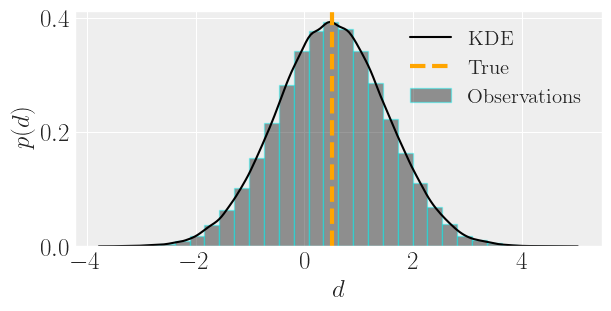

In [3]:
# Plot the generated data.

fig, ax = plt.subplots(1,1,figsize=(6,3))
plt.hist(data,density=True,label='Observations',bins=30,histtype = 'bar',
                               color ='black', alpha=0.4, edgecolor='cyan')
sns.kdeplot(np.array(data), label='KDE',c='black')
plt.axvline(x=true_mu, label='True', c='orange',ls='--',lw=3)

plt.xlabel('$d$')
plt.ylabel('$p(d)$')
plt.legend(loc='best')

Below we define the model we use in the MCMC analysis. For this simplified scenario, we assume $\sigma^2$ is known in the variance, since in the end we want to compare posterior samples with expressions that do contain this element $\sigma^2$.

The fact above however does not mean we do not expect biases, since we draw $p(d|\lambda)$ from a random.normal distribution, which reintroduces an element of statistical noise.

In [4]:
def model(d,mu,Sigma_sq):
    
    """
    Model for p(d|lambda).
    
    Input:
    
    - data              (The noisy generated data where we expect theta to be.)
    - mu                (First  hyperparameter, "param[0]" in MCMC initialization.)
    - Sigma^2 + sigma^2 (Second hyperparameter, "param[1]" in MCMC initialization.)
    
    """
    num = np.exp(-0.5*(d-mu)**2/Sigma_sq)
    den = np.sqrt(2*np.pi*Sigma_sq)
    return num/den

## Fitting without selection effects

Below we define the likelihood. In principle we define it as the product of the gaussians from individual observations,

$$
p(d|\lambda) \equiv \Lambda = \prod_{i=1}^{N_\text{obs}} p(d_i|\lambda), \quad
\log \Lambda = \sum_{i}^{N_\text{obs}} \log p(d_i|\lambda)
,
$$

where $d_i$ are draws from the data array.

$\textit{Note:}$ in this case the model is simple enough that we have the luxury to sample directly $p(d|\lambda)$. Thus we bypass the need to draw samples $p(d|\theta)$ to marginalize over source parameters $\theta$ with a population model $p(\theta|\lambda)$.

In [5]:
# Define limits of support for the likelihood, i.e. the limits of flat priors.

mean_min_prior = -5.0
mean_max_prior = 5.0

Sigma_sq_min_prior = -5.0
Sigma_sq_max_prior = 5.0


def log_likelihood(params, data):
    
    # Specify a set of flat priors.
    support = (
                (params[0] >= mean_min_prior)&
                (params[0] <= mean_max_prior)&
                (params[1] >= Sigma_sq_min_prior)&
                (params[1] <= Sigma_sq_max_prior)
                )
    
    #Likelihood is a gaussian with mean given by params[0] and Sigma given by params[1].
    #Sum in the log-likelihood sums over individual observations.
    
    mod = model(data,params[0],params[1])
    log_likelihood = np.sum(np.log(mod))

    
    # Output is the likelihood where there is support.
    
    out = np.where(support,log_likelihood,-np.inf)
    
    # Force nans away.
    if np.isfinite(out):
        return out
    else:
        return -np.inf

Run the sampler

In [6]:
n_iter = 10000
ndim, nwalkers = 2, 4

# Initialize MCMC: here's where params[0] and params[1] are effectively defined.

pos_init0 = [true_mu, true_Sigma_sq + sigma**2]

# Perturb the initial position by a bit, so that we do not start exactly on top of 
# the hyperparameters we want to infer.

p0 = pos_init0*(1+0.001* np.random.randn(2*len(pos_init0), len(pos_init0)))


# Run the MCMC here.

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[data])
run = sampler.run_mcmc(p0, n_iter, progress=True)

100%|████████████████████████████████████| 10000/10000 [00:58<00:00, 172.10it/s]


## Results and diagnostics

We run some diagnostics using the arviz package. We gather some interactive data from emcee's results with the following lines.

In [7]:
# define variable names, it cannot be inferred from emcee
var_names = ["mu","Sigmasq"]
idata1 = az.from_emcee(sampler, var_names=var_names) # interactive data.

We check the summary statistics and plot trace and posterior here

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,0.5010,0.0031,0.4950,0.5067,0.0001,0.0001,714.8725,2610.0794,1.0050
Sigmasq,1.0113,0.0044,1.0026,1.0194,0.0002,0.0001,807.1213,2339.6153,1.0034


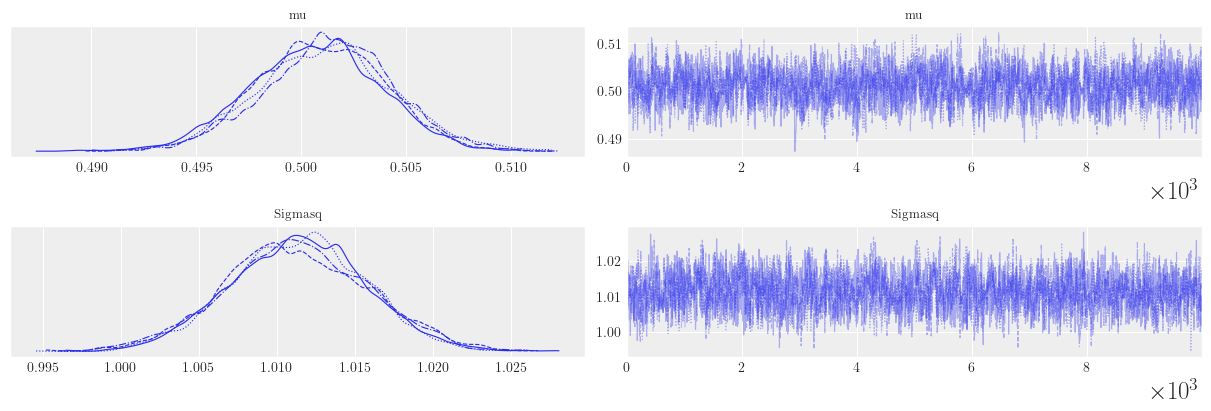

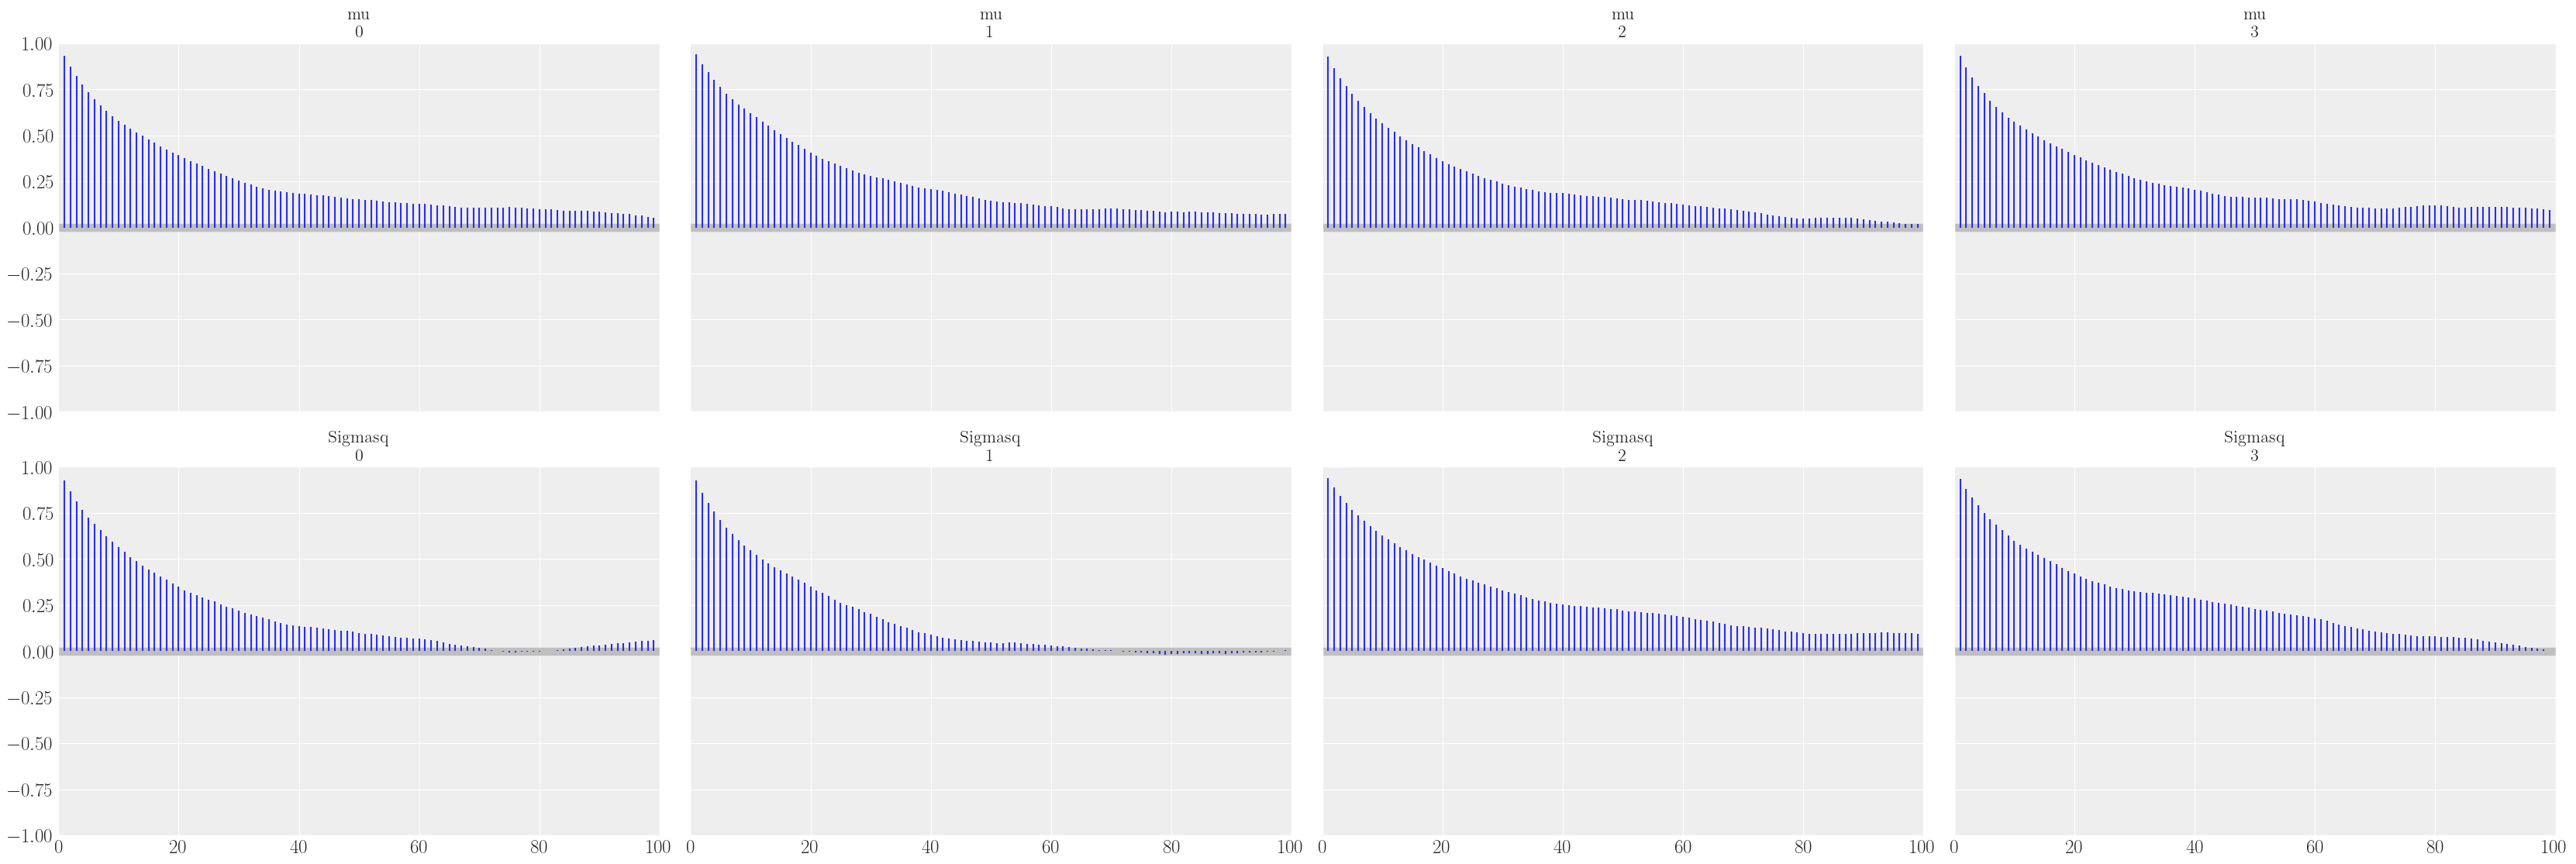

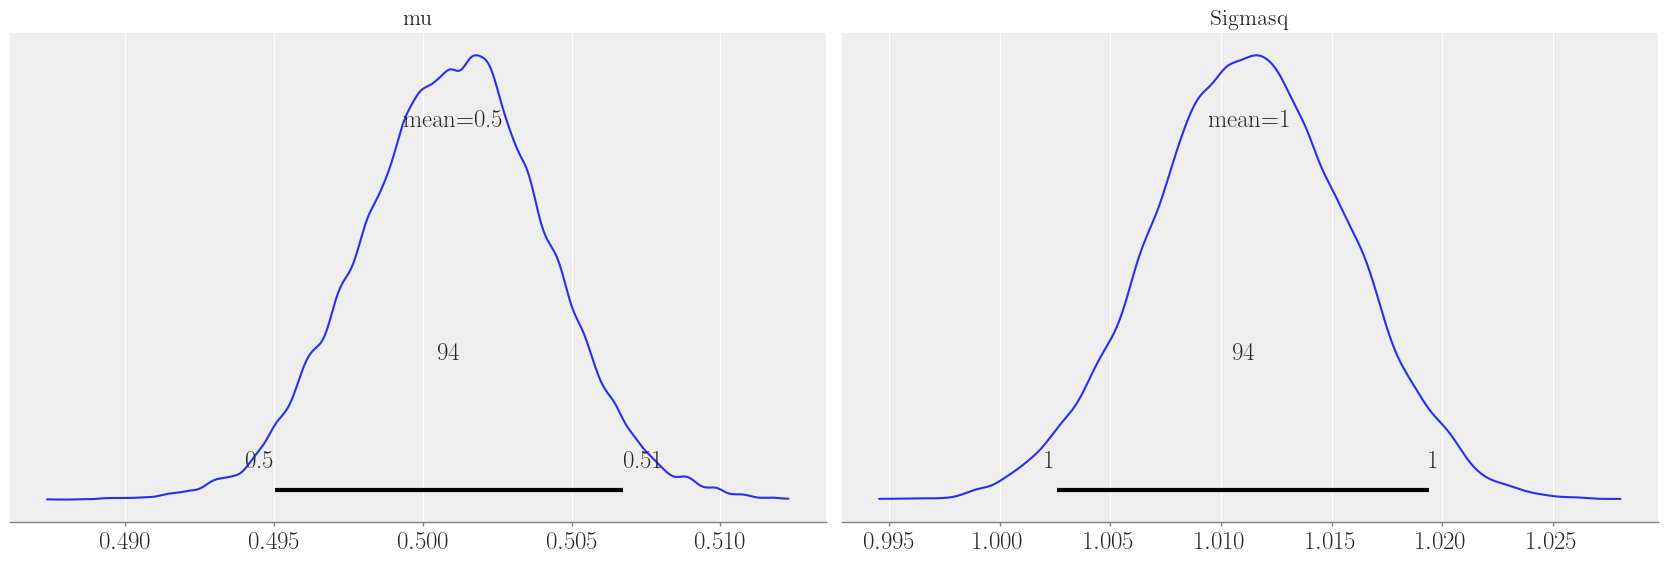

In [8]:
display(az.summary(idata1, round_to=4))         # Summary statistics.
az.plot_trace(idata1, var_names=var_names);     # Plot traces.
az.plot_autocorr(idata1, var_names=var_names);  # Plot autocorrelation.
az.plot_posterior(idata1, var_names=var_names); # Plot posterior distribution.

Plot the 2D posterior.

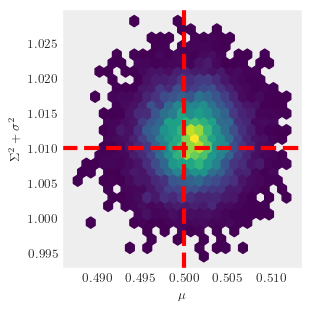

In [9]:
labeller = az.labels.MapLabeller(var_name_map={"mu": r"$\mu$","Sigmasq": r"$\Sigma^2 + \sigma^2$"})
az.plot_pair(
    idata1,
    var_names=var_names,
    labeller=labeller,
    kind="hexbin",
    colorbar=False,
    divergences=False,
    figsize= (3,3)
)
plt.axvline(x=pos_init0[0], label='True', c='red',ls='--', lw=3)
plt.axhline(y=pos_init0[1], label='True', c='red',ls='--', lw=3)
plt.show()

Extract the samples from the sampler.

In [10]:
"""
Collect the samples here.
"""
burnin = 1500 # discard first 1500 points.

chains = sampler.get_chain(discard=burnin, thin=1, flat=False)
mu_samples = chains[:,:,0].flatten()
Sigma2_samples = chains[:,:,1].flatten() - sigma**2 # remove sigma component to show results for Sigma^2 only.
org_samp = np.vstack( (mu_samples, Sigma2_samples) ).T

print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (34000, 2)
median =  [0.50106876 1.00124726]


## Matching MCMC results to the Fisher estimate

The Fisher matrix for the simple Gaussian case without selection effects is found to be

$$
\Gamma_\lambda = \begin{pmatrix}
\Gamma_{\mu\mu} & \Gamma_{\mu\Sigma^2}\\
\Gamma_{\mu\Sigma^2} & \Gamma_{\Sigma^2\Sigma^2}
\end{pmatrix}
$$

with 

$$
\Gamma_{\mu\mu}= \frac{1}{\sigma^2+\Sigma^2}, \quad \Gamma_{\mu\Sigma^2} = 0,\quad \Gamma_{\Sigma^2\Sigma^2} = \frac{1}{2(\sigma^2+\Sigma^2)^2}.
$$

[Details on how to obtain these are included in the paper.]

In [11]:
Gamma_mu_mu = 1/(sigma**2 + true_Sigma_sq)
Gamma_Ssq_Ssq = 0.5*1/(sigma**2 + true_Sigma_sq)**2

Gamma_lambda = [[Gamma_mu_mu,0],[0,Gamma_Ssq_Ssq]]
Gamma_lambda_inv = np.linalg.inv(Gamma_lambda)

To match the width from the MCMC results we need to normalize the Fisher matrix results by the number of observed events (the $N^{-1/2}$) factor. That is because the matrix is derived for an individual observation, while the MCMC results are obtained with $N$-long data arrays.

In [12]:
Dlambda_diag = 1/np.sqrt(N_obs) *  np.sqrt(np.diag(Gamma_lambda_inv)) #renormalization.
Dmu, DSigma_sq = Dlambda_diag[0], Dlambda_diag[1]

A simplified version of the Fisher matrix without selection effects reads

$$
(\Gamma_\lambda)_{ij} = \int \frac{1}{p(\theta|\lambda)}\frac{\partial p(\theta|\lambda)}{\partial \lambda^i}\frac{\partial p(\theta|\lambda)}{\partial \lambda^j}d\theta = \int p(\theta|\lambda)\frac{\partial \ln p(\theta|\lambda)}{\partial \lambda^i}\frac{\partial \ln p(\theta|\lambda)}{\partial \lambda^j}d\theta
$$

We can calculate this easily to give $\Gamma_{\mu\mu}= \frac{1}{\Sigma^2}, \quad \Gamma_{\mu\Sigma^2} = 0,\quad \Gamma_{\Sigma^2\Sigma^2} = \frac{1}{2\Sigma^4}$. We have used that $p(\theta|\lambda)=\mathcal{N}(\mu,\sigma^2+\Sigma^2)$.

The inverse of the Fisher matrix is then

$$
(\Gamma_\lambda)_{ij}^{-1} =\begin{pmatrix}
\Sigma^2 & 0 \\
0 & 2 \Sigma^4
\end{pmatrix}
$$

[Details on how to obtain these are given in the Mathematica notebook in this folder.]

In [13]:
Gamma_lambda_inv_simplified = [[true_Sigma_sq,0],[0,2 * true_Sigma_sq**2 ]]
Dlambda_diag_simplified = 1/np.sqrt(N_obs) *  np.sqrt(np.diag(Gamma_lambda_inv_simplified))
Dmu_simplified, DSigma_sq_simplified = Dlambda_diag_simplified[0], Dlambda_diag_simplified[1]

We can check that the Fisher estimates agree with the variance of the samples, and more directly against the posterior distributions. 

In [14]:
print('FM (full) widths',Dlambda_diag)
print('FM (approx.) widths',Dlambda_diag_simplified)
print('MCMC widths:',[np.round(np.sqrt(np.var(mu_samples)),8),np.round(np.sqrt(np.var(Sigma2_samples)),8)])

FM (full) widths [0.00317805 0.00451686]
FM (approx.) widths [0.00316228 0.00447214]
MCMC widths: [0.00315581, 0.00444684]


Then we can produce some plots that highlight this more visually

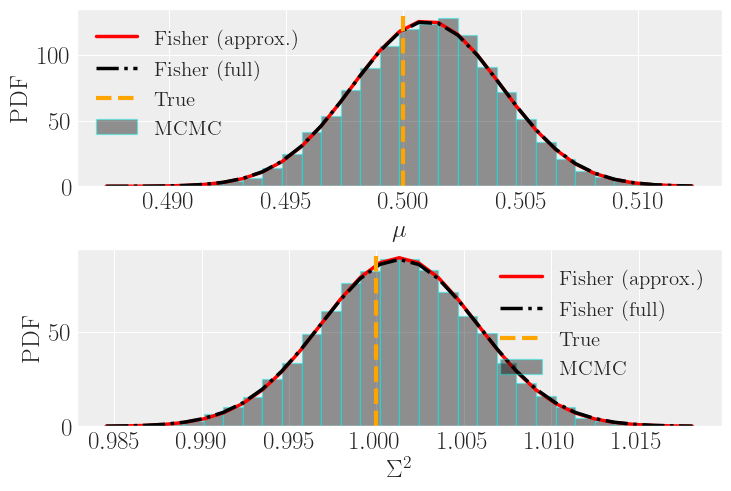

In [15]:
# Mean

plt.subplot(2,1,1)
truths=[true_mu, true_Sigma_sq]

_, bins_mu, _= plt.hist(mu_samples, 30, histtype = 'bar', edgecolor='cyan',
                        color ='black', alpha=0.4, density=True,
                        label='MCMC')

bins_mu= np.array(bins_mu)
plt.plot(bins_mu, model(bins_mu,true_mu + 0.001,Dmu_simplified**2), color='red', 
         lw=2.5, label='Fisher (approx.)')
plt.plot(bins_mu, model(bins_mu,true_mu + 0.001,Dmu**2), color='black', ls='-.', 
         lw=2.5, label='Fisher (full)')

plt.axvline(x=truths[0], label='True', c='orange',ls='--',lw=3)
plt.xlabel('$\mu$')
plt.ylabel('PDF')
plt.legend()

# Std

plt.subplot(2,1,2)
_, bins_Ssq, _=plt.hist(Sigma2_samples, 30, histtype = 'bar', edgecolor='cyan',
                        color ='black', alpha=0.4, density=True,
                        label='MCMC')

bins_Ssq= np.array(bins_Ssq)
plt.plot(bins_Ssq, model(bins_Ssq,true_Sigma_sq+0.0013,DSigma_sq_simplified**2), color='red',
         lw=2.5,label='Fisher (approx.)')
plt.plot(bins_Ssq, model(bins_Ssq,true_Sigma_sq+0.0013,DSigma_sq**2), color='black', ls='-.',
         lw=2.5,label='Fisher (full)')

plt.axvline(x=truths[1], label='True', c='orange',ls='--', lw=3)
plt.xlabel('$\Sigma^2$')
plt.ylabel('PDF')
plt.legend()
plt.show()